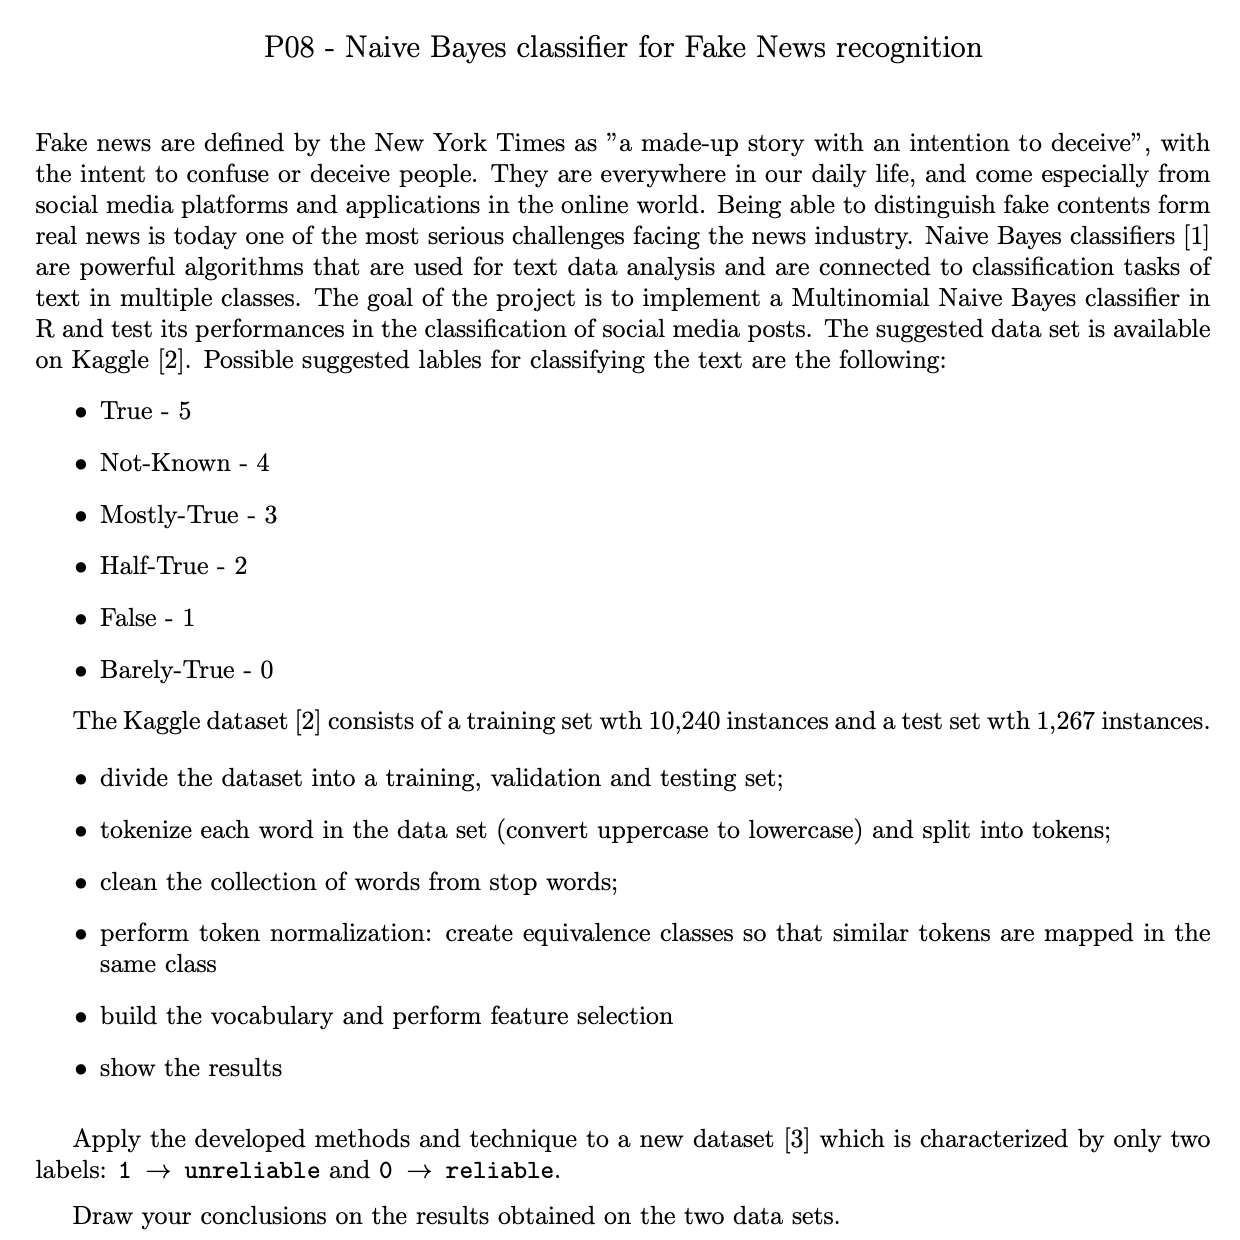

# Multinomial Naive Bayes Classifier

**Goal:** Classify a document *d* into one of *K* classes $C_k$, given its words.


## 1. Bayes' Theorem

$$
P(C_k \mid d) = \frac{P(d \mid C_k) \cdot P(C_k)}{P(d)}
$$

Since  $P(d)$ is constant across classes, we use:

$$
\arg\max_{C_k} \left[ P(d \mid C_k) \cdot P(C_k) \right]
$$


## 2. Multinomial Model

- Represent document *d* as a vector of word counts:  
- $ d = n_1, n_2, \dots, n_V $
- $V$ is the size of the vocabulary.
- $n_i$ is the number of times word $w_i$ appears in document *d*.

$$
P(d \mid C_k) = \frac{N_d!}{\prod_{i=1}^{V} n_i!} \prod_{i=1}^{V} \left( P(w_i \mid C_k) \right)^{n_i}
$$

In practice, we ignore the multinomial coefficient and compute:

$$
\log P(d \mid C_k) = \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$


## 3. Priors

$$
P(C_k) = \frac{\text{Number of documents in class } C_k}{\text{Total number of documents}}
$$


## 4. Likelihoods with Smoothing

$$
P(w_i \mid C_k) = \frac{N_{ik} + \alpha}{N_k + \alpha V}
$$

Where:

- $N_{ik}$ = number of times word $w_i$ occurs in documents of class $C_k$
- $N_k$ = total number of words in documents of class $C_k$
- $\alpha$ = smoothing parameter (usually $\alpha = 1$, Laplace smoothing)
- $V$ = size of vocabulary


## 5. Prediction Rule

For a given document *d*, compute for each class:

$$
\log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k)
$$

Choose the class with the highest score:

$$
\hat{C} = \arg\max_{C_k} \left[ \log P(C_k) + \sum_{i=1}^{V} n_i \cdot \log P(w_i \mid C_k) \right]
$$


## 6. Summary of Training Steps

1. Compute $P(C_k)$ for each class.
2. For each word $w_i$ and each class $C_k$, compute $P(w_i \mid C_k)$ with smoothing.


## 7. Summary of Prediction Steps

1. For a new document *d*, compute the score for each class.
2. Choose the class with the highest score.



---
# Load the datasets

In [105]:
# Load the required libraries
library(ggplot2)
library(tidytext)
library(dplyr)
library(tm)
library(tidyr)
library(SnowballC)

In [106]:
# Load the training and testing datasets
train_data = read.csv("data/train.csv")
test_data = read.csv("data/test.csv")

In [107]:
# Divide the training dataset into training and validation set. 20% of the data will be used for validation.

set.seed(123)  # For reproducibility

train_indices = sample(1:nrow(train_data), size = 0.8 * nrow(train_data))
train_data = train_data[train_indices, ]
validation_data = train_data[-train_indices, ]

In [108]:
print("--------- Training Data Summary ---------")
summarize(train_data,
          num_rows = n(), 
          num_cols = ncol(train_data),
          num_missing = sum(is.na(train_data)))

print("--------- Validation Data Summary ---------")
summarise(validation_data,
          num_rows = n(),
          num_cols = ncol(validation_data),
          num_missing = sum(is.na(validation_data)))

print("--------- Testing Data Summary ---------")
summarise(test_data,
          num_rows = n(),
          num_cols = ncol(test_data),
          num_missing = sum(is.na(test_data)))

[1] "--------- Training Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
8192,3,0


[1] "--------- Validation Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1612,3,0


[1] "--------- Testing Data Summary ---------"


num_rows,num_cols,num_missing
<int>,<int>,<int>
1267,2,0


In [109]:
train_data = train_data %>% mutate(doc_id = row_number())
validation_data = validation_data %>% mutate(doc_id = row_number())
test_data = test_data %>% mutate(doc_id = row_number())

In [110]:
train_data$Text = as.character(train_data$Text)
validation_data$Text = as.character(validation_data$Text)
test_data$Text = as.character(test_data$Text)

In [111]:
train_data[0:5,]

,Labels,Text,Text_Tag,doc_id
,<int>,<chr>,<chr>,<int>
2463,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1
2511,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2
8718,5,Michael Thurmond authored major legislation that has provided more than $250 million in tax relief to Georgias senior citizens and working families.,taxes,3
2986,3,"Palin ""fired Wasilla's Police Chief because he 'intimidated' her.""",crime,4
1842,5,[L]ess than one-tenth of Atlantas transportation needs are covered in a referendum to levy a 1-cent sales tax.,transportation,5


### Possible labels of the data
- False: 1
- Half-True: 2
- Mostly-True: 3
- Not-Known: 4
- True: 5
- Barely-True: 0

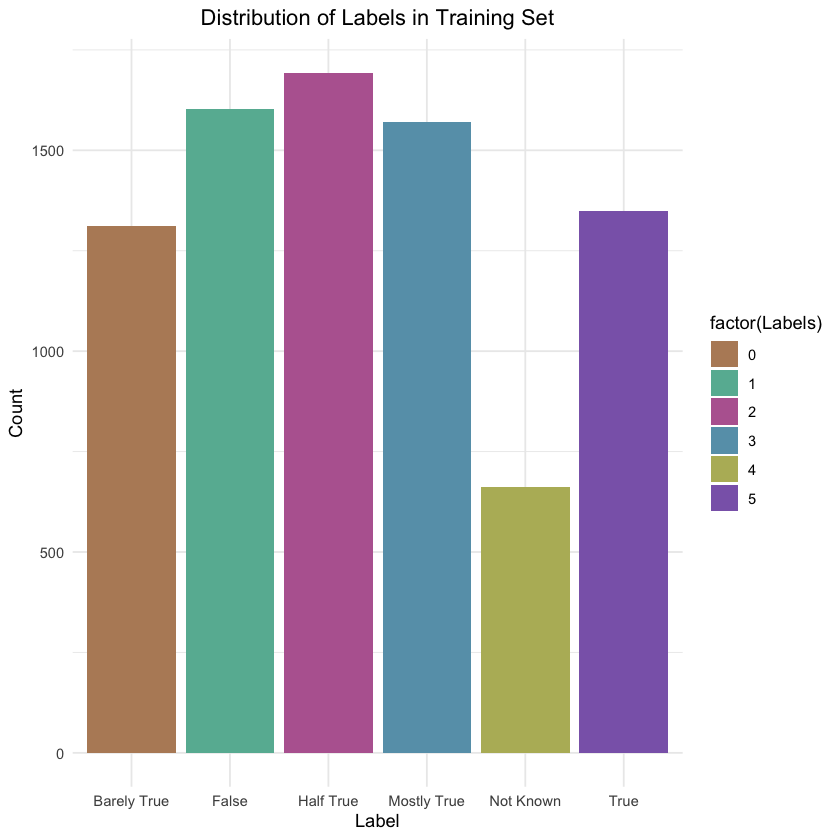

In [112]:
ggplot(train_data, aes(x = factor(Labels), fill = factor(Labels))) +
  geom_bar() +
  labs(title = "Distribution of Labels in Training Set",
       x = "Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_discrete(labels = c("0" = "Barely True", 
                               "1" = "False", 
                               "2" = "Half True", 
                               "3" = "Mostly True", 
                               "4" = "Not Known", 
                               "5" = "True")) +
  scale_fill_manual(values = c("0" = "#b78b67", 
                               "1" = "#67b7a1", 
                               "2" = "#b7679f", 
                               "3" = "#679fb7", 
                               "4" = "#b7b767", 
                               "5" = "#8b67b7"))

# Tokenization
We tokenize all of the datasets such that each datapoint will be a vector of the words it contains. All of the letters are converted into lowercase. The punctuation is removed. Stopwords such as "and", "of", or "the" are also removed. We replace numbers with a < number > placeholder unless it includes a dollar sign ($) or a percentage (%)

In [113]:
tokenize_and_clean_text <- function(data_frame) {
  data_frame %>% # nolint
    # Tokenize the text into individual words (from tidytext library)
    unnest_tokens(word, Text, drop = FALSE) %>%
    # Remove punctuation (uses regex to match punctuation characters)
    mutate(word = gsub("[[:punct:]]", "", word)) %>%
    # Replace numbers with a placeholder unless they start with $ or end with %
    mutate(word = ifelse(grepl("^\\$[0-9]+|[0-9]+%$", word), 
                         word, 
                         gsub("[[:digit:]]+", "<number>", word))) %>%
    # Create equivalence classes
    # mutate(word = wordStem(word, language = "en")) %>% # REDUCED THE VALIDATION ACCURACY BY 5% :OOOO
    # Remove English stopwords
    anti_join(stop_words, by = "word") %>%
    # Filter out any empty strings
    filter(word != "") %>%
    # Filter out single-character words
    filter(nchar(word) > 1)
}

In [114]:
tokenized_train_data = tokenize_and_clean_text(train_data)
tokenized_test_data = tokenize_and_clean_text(test_data)
tokenized_validation_data = tokenize_and_clean_text(validation_data)

# To avoid words that are not used during training. This should increase the validation accuracy significantly.
vocab <- unique(tokenized_train_data$word)

tokenized_validation_data <- tokenized_validation_data %>%
  filter(word %in% vocab)

tokenized_test_data <- tokenized_test_data %>%
  filter(word %in% vocab)


# Enforce doc_id coverage for test data
test_data <- test_data %>% mutate(doc_id = row_number())

# Recreate tokenized_test_data from raw if needed
tokenized_test_data <- tokenize_and_clean_text(test_data)

# Filter test tokens to match training vocab only
vocab <- unique(tokenized_train_data$word)
tokenized_test_data <- tokenized_test_data %>% filter(word %in% vocab)



In [115]:
tokenized_train_data[7:15, ]

,Labels,Text,Text_Tag,doc_id,word
,<int>,<chr>,<chr>,<int>,<chr>
7,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1,raising
8,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1,property
9,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1,taxes
10,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1,<number>
11,4,Says Wisconsin Gov. Scott Walkers budget calls for raising property taxes by nearly $500 billion.,"state-budget,taxes",1,billion
12,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2,californias
13,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2,credit
14,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2,rating
15,5,Californias credit rating is the worst in the country.,"economy,message-machine,state-budget",2,worst


# Document-term matrices

In [116]:
create_dtm <- function(tokenized_data, total_docs = NULL, tfidf = FALSE) {
  if (!all(c("doc_id", "word") %in% colnames(tokenized_data))) {
    stop("The data must contain 'doc_id' and 'word' columns.")
  }

  if (!is.null(total_docs)) {
    all_doc_ids <- data.frame(doc_id = 1:total_docs)
    tokenized_data <- all_doc_ids %>%
      left_join(tokenized_data, by = "doc_id") %>%
      filter(is.na(word) | word != "")
  }

  word_counts <- tokenized_data %>%
    count(doc_id, word)

  dtm <- word_counts %>%
    cast_dtm(document = doc_id, term = word, value = n)

  if (tfidf) {
    dtm <- weightTfIdf(dtm)
  }

  return(dtm)
}


In [117]:
# Then create DTM using tf-idf
test_matrix <- create_dtm(tokenized_test_data, total_docs = nrow(test_data), tfidf = TRUE)
training_matrix <- create_dtm(tokenized_train_data, tfidf = TRUE)
validation_matrix <- create_dtm(tokenized_validation_data, tfidf = TRUE)

inspect(training_matrix)

<<DocumentTermMatrix (documents: 8192, terms: 10099)>>
Non-/sparse entries: 69888/82661120
Sparsity           : 100%
Maximal term length: 23
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)
Sample             :
      Terms
Docs   <number> care health jobs million obama people percent president tax
  1852        0    0      0    0       0     0      0       0         0   0
  3041        0    0      0    0       0     0      0       0         0   0
  3267        0    0      0    0       0     0      0       0         0   0
  3933        0    0      0    0       0     0      0       0         0   0
  5689        0    0      0    0       0     0      0       0         0   0
  6398        0    0      0    0       0     0      0       0         0   0
  7545        0    0      0    0       0     0      0       0         0   0
  759         0    0      0    0       0     0      0       0         0   0
  7799        0    0      0    0       0     0      0  

In [118]:
dim(training_matrix)
dim(validation_matrix)
dim(test_matrix)

[1]  8192 10099

[1] 1612 4228

[1] 1267 2998

# Naive Bayes Classifier Main Functions

In [129]:
test_matrix <- as.matrix(test_matrix)  # ensure base R matrix
test_matrix <- apply(test_matrix, 2, as.numeric)  # coerce all to numeric


predict_naive_bayes <- function(matrix, priors, log_likelihoods, classes) {
  predictions <- vector("character", nrow(matrix))
  vocab <- colnames(matrix)
  
  for (i in 1:nrow(matrix)) {
    doc <- as.numeric(matrix[i, ])
    names(doc) <- colnames(matrix)  # important for word-based lookup
    scores <- sapply(classes, function(class) {
      shared_words <- intersect(vocab, names(log_likelihoods[[class]]))
      if (length(shared_words) == 0) return(-Inf)
      sum(doc[shared_words] * log_likelihoods[[class]][shared_words]) + log(priors[class])
    })
    predictions[i] <- classes[which.max(scores)]
  }
  
  return(predictions)
}

train_naive_bayes <- function(training_matrix, train_labels, validation_matrix, validation_labels) {
  train_labels <- as.factor(train_labels)
  validation_labels <- as.factor(validation_labels)
  classes <- levels(train_labels)
  
  priors <- table(train_labels) / length(train_labels)
  
  likelihoods <- list()
  for (class in classes) {
    class_rows <- training_matrix[train_labels == class, ]
    word_totals <- colSums(class_rows) + 1
    likelihoods[[class]] <- word_totals / sum(word_totals)
  }
  
  epsilon <- 1e-10
  vocab <- colnames(training_matrix)
  log_likelihoods <- list()
  for (class in classes) {
    log_likelihoods[[class]] <- sapply(vocab, function(word) {
      if (word %in% names(likelihoods[[class]])) {
        log(likelihoods[[class]][[word]])
      } else {
        log(epsilon)
      }
    })
  }

  # Use external prediction function
  validation_predictions <- predict_naive_bayes(validation_matrix, priors, log_likelihoods, classes)
  confusion_matrix <- table(Predicted = validation_predictions, Actual = validation_labels)
  accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
  
  print("Confusion Matrix:")
  print(confusion_matrix)
  print(paste("Validation Accuracy:", round(accuracy * 100, 2), "%"))

  return(list(
    priors = priors,
    likelihoods = likelihoods,
    log_likelihoods = log_likelihoods,
    classes = classes,
    predictions = validation_predictions,
    confusion_matrix = confusion_matrix
  ))
}


In [130]:
# Example usage
model <- train_naive_bayes(as.matrix(training_matrix), 
                           train_data$Labels,  # Replace with the correct training labels
                           as.matrix(validation_matrix), 
                           validation_data$Labels)  # Replace with the correct validation labels

[1] "Confusion Matrix:"
         Actual
Predicted   0   1   2   3   4   5
        0 183  13  10   9   5   6
        1  18 233  16  11  13  22
        2  37  30 249  27  15  30
        3  19  27  26 237  11  23
        4   0   1   0   1  80   1
        5  13  13  15  13   4 201
[1] "Validation Accuracy: 73.39 %"


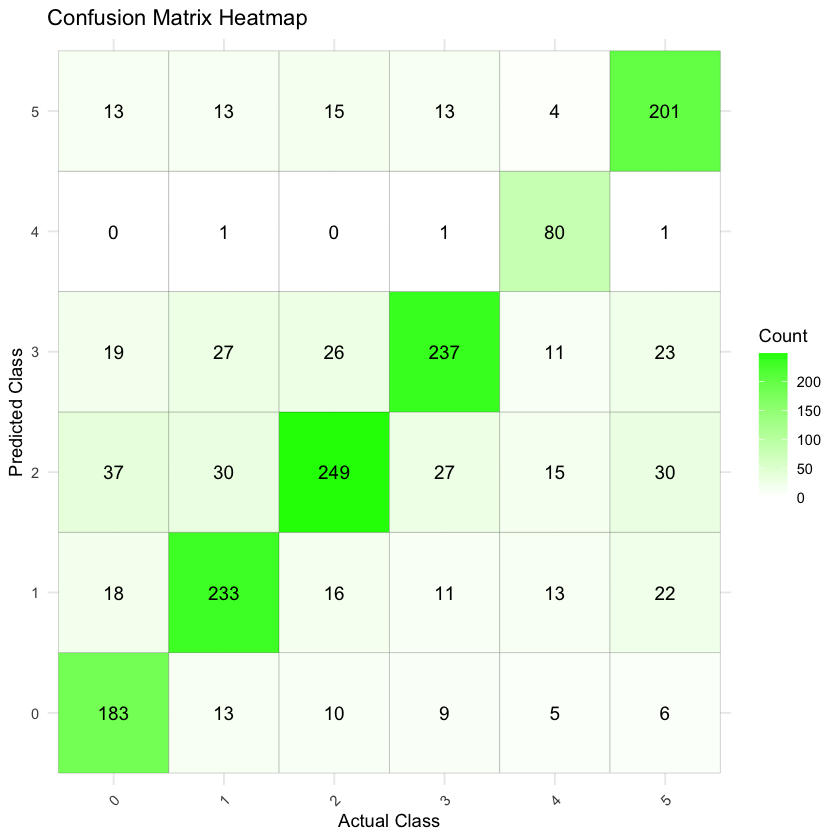

In [131]:
confusion_matrix = model$confusion_matrix

cm_df <- as.data.frame(confusion_matrix)
colnames(cm_df) <- c("Predicted", "Actual", "Count")

ggplot(cm_df, aes(x = Actual, y = Predicted, fill = Count)) +
  geom_tile(color = "black", linewidth = 0.05) +
  geom_text(aes(label = Count), color = "black", size = 4) +
  scale_fill_gradient(low = "white", high = "green") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap",
       x = "Actual Class",
       y = "Predicted Class") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


# Test evaluation

In [132]:
test_predictions <- predict_naive_bayes(test_matrix, 
                                        model$priors, 
                                        model$log_likelihoods, 
                                        model$classes)

In [133]:
table(test_predictions)

test_predictions
  0   1   2   3   4   5 
155 261 351 312  39 149 

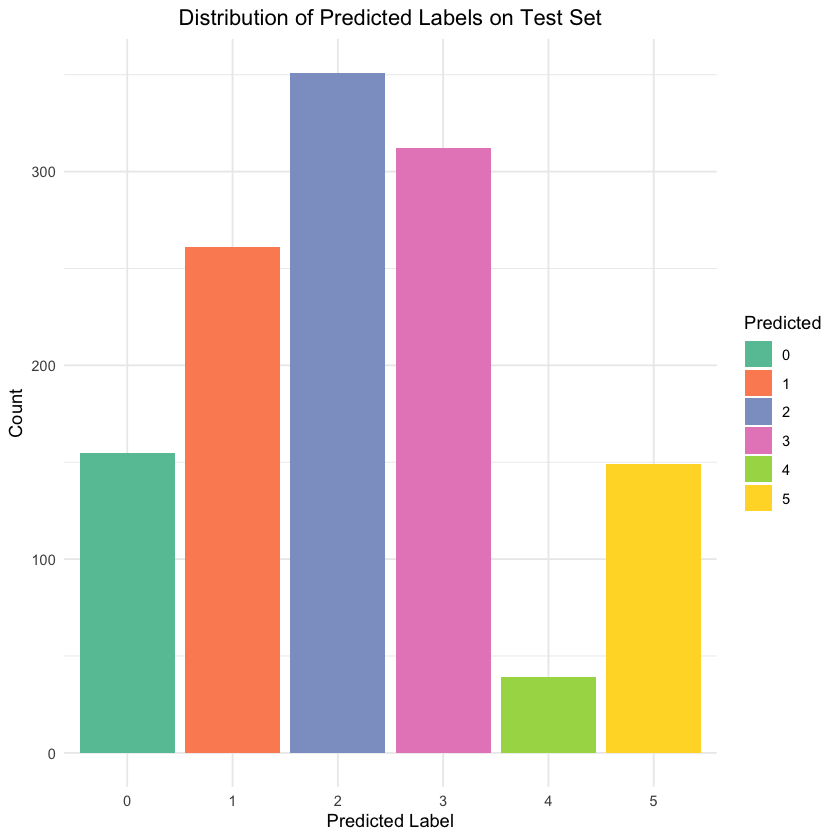

In [134]:
library(ggplot2)

# Convert to data frame
pred_df <- data.frame(Predicted = test_predictions)

# Plot
ggplot(pred_df, aes(x = Predicted, fill = Predicted)) +
  geom_bar() +
  labs(title = "Distribution of Predicted Labels on Test Set",
       x = "Predicted Label",
       y = "Count") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_fill_brewer(palette = "Set2")
